# Statistical Analysis

In [1]:
import numpy as np
import pandas as pd
import sqlite3

In [2]:
cursor = sqlite3.connect('../database/sstubs.db').cursor()
data = list(cursor.execute('SELECT * FROM sstubs_large'))
columns = cursor.execute(
    "SELECT name FROM PRAGMA_TABLE_INFO('sstubs_large')"
)
sstubs_df = pd.DataFrame(data=data, columns=[col for col, in columns])

In [3]:
sstubs_df.iloc[0]

parent              9d35cf00d8e3a28f8bacb48a9a16aeceb974325d
child               796f45d14550420d66e1ed28daefeb45874d195f
type                          CHANGE_CALLER_IN_FUNCTION_CALL
project                                            ACRA.acra
file       acra-limiter/src/main/java/org/acra/config/Lim...
line                                                      83
before                               stacktrace.indexOf(':')
after                                 firstLine.indexOf(':')
Name: 0, dtype: object

In [4]:
sstubs_df = sstubs_df.merge(
    right=pd.read_csv('../database/sstubs_large_distances.csv'),
    left_on='child',
    right_on='commit'
)

In [5]:
sstubs_df.iloc[0]

parent               9d35cf00d8e3a28f8bacb48a9a16aeceb974325d
child                796f45d14550420d66e1ed28daefeb45874d195f
type                           CHANGE_CALLER_IN_FUNCTION_CALL
project                                             ACRA.acra
file        acra-limiter/src/main/java/org/acra/config/Lim...
line                                                       83
before                                stacktrace.indexOf(':')
after                                  firstLine.indexOf(':')
commit               796f45d14550420d66e1ed28daefeb45874d195f
distance                                                    1
Name: 0, dtype: object

In [6]:
stat_df = sstubs_df[['parent', 'child', 'type', 'distance']]
fix_df = stat_df[stat_df.distance > 1]
stat_df.iloc[0]

parent      9d35cf00d8e3a28f8bacb48a9a16aeceb974325d
child       796f45d14550420d66e1ed28daefeb45874d195f
type                  CHANGE_CALLER_IN_FUNCTION_CALL
distance                                           1
Name: 0, dtype: object

## General Exploration

array([[<AxesSubplot:title={'center':'distance'}>]], dtype=object)

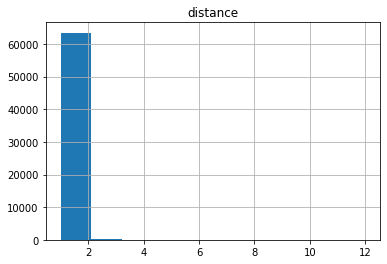

In [7]:
stat_df.hist()

array([[<AxesSubplot:title={'center':'distance'}>]], dtype=object)

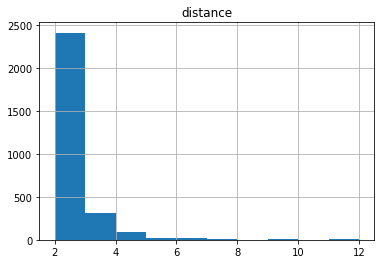

In [8]:
fix_df.hist()

In [9]:
stat_df.describe(percentiles=[.01, .90, .99, .999])

,distance
count,63923.000000
mean,1.057960
std,0.325925
min,1.000000
1%,1.000000
50%,1.000000
90%,1.000000
99%,2.000000
99.9%,5.000000
max,12.000000


> The min value for `distance` is `1`.
> This is because `distance` is `0` for the commits without parents.
> There is no dedicated row for such commits in `sstubs_large`.

In [10]:
fix_df.describe(percentiles=[.75, .85, .90, .99])

,distance
count,2881.000000
mean,2.286012
std,0.881981
min,2.000000
50%,2.000000
75%,2.000000
85%,3.000000
90%,3.000000
99%,7.000000
max,12.000000


In [11]:
stat_df.groupby('distance').agg('size')

distance
1     61042
2      2408
3       315
4        86
5        22
6        20
7        15
8         3
9         5
10        2
11        3
12        2
dtype: int64

In [12]:
print(f'SStuBs Skewness: {stat_df.distance.skew()}')
print(f'Fix Skewness: {fix_df.distance.skew()}')

SStuBs Skewness: 10.805853473940637
Fix Skewness: 5.2347588033480426


In [13]:
print(f'SStuBs Kurtosis: {stat_df.distance.kurt()}')
print(f'Fix Kurtosis: {fix_df.distance.kurt()}')

SStuBs Kurtosis: 199.9706992380031
Fix Kurtosis: 36.5528411726385


## Bug Type Wise Exploration


### Description

In [14]:
describe_df = fix_df.groupby(by='type').distance.describe()\
    .sort_values('mean', ascending=False)
describe_df

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
CHANGE_MODIFIER,156.0,2.955128,2.345464,2.0,2.0,2.0,2.0,12.0
CHANGE_NUMERAL,295.0,2.454237,0.538113,2.0,2.0,2.0,3.0,4.0
DIFFERENT_METHOD_SAME_ARGS,849.0,2.282686,0.801057,2.0,2.0,2.0,2.0,8.0
CHANGE_IDENTIFIER,1086.0,2.256906,0.761591,2.0,2.0,2.0,2.0,8.0
CHANGE_CALLER_IN_FUNCTION_CALL,31.0,2.193548,0.401610,2.0,2.0,2.0,2.0,3.0
LESS_SPECIFIC_IF,32.0,2.093750,0.296145,2.0,2.0,2.0,2.0,3.0
CHANGE_OPERAND,12.0,2.083333,0.288675,2.0,2.0,2.0,2.0,3.0
OVERLOAD_METHOD_MORE_ARGS,92.0,2.043478,0.205049,2.0,2.0,2.0,2.0,3.0
CHANGE_UNARY_OPERATOR,24.0,2.041667,0.204124,2.0,2.0,2.0,2.0,3.0


### Histogram

In [15]:
def plot_hist(sharey = True):
    axes = fix_df.hist(
        column='distance',
        by='type',
        bins=[i+2 for i in range(10)],
        sharey=sharey,
        layout=(-1, 2),
        figsize=(10, 75),
        color='#0092A6'
    )

    vip_types = ['CHANGE_MODIFIER', 'CHANGE_NUMERAL']
    ip_types = [
        'DIFFERENT_METHOD_SAME_ARGS',
        'CHANGE_IDENTIFIER',
        'CHANGE_CALLER_IN_FUNCTION_CALL',
    ]

    vip_clr, ip_clr, clr = 'magenta', 'lime', 'skyblue'

    for row_ax in axes:
        for ax in row_ax:
            _clr = clr
            if ax.get_title() in vip_types:
                _clr = vip_clr
            elif ax.get_title() in ip_types:
                _clr = ip_clr
            ax.title.set_color(_clr)
            ax.tick_params(axis='x', colors='white')
            ax.tick_params(axis='y', colors='white')

    return axes

#### Same Height
> In the following plots, all histograms will have the same height.
> This will help to compare how refixes are distributed among all bug-types.

array([[<AxesSubplot:title={'center':'ADD_THROWS_EXCEPTION'}>,
        <AxesSubplot:title={'center':'CHANGE_CALLER_IN_FUNCTION_CALL'}>],
       [<AxesSubplot:title={'center':'CHANGE_IDENTIFIER'}>,
        <AxesSubplot:title={'center':'CHANGE_MODIFIER'}>],
       [<AxesSubplot:title={'center':'CHANGE_NUMERAL'}>,
        <AxesSubplot:title={'center':'CHANGE_OPERAND'}>],
       [<AxesSubplot:title={'center':'CHANGE_OPERATOR'}>,
        <AxesSubplot:title={'center':'CHANGE_UNARY_OPERATOR'}>],
       [<AxesSubplot:title={'center':'DELETE_THROWS_EXCEPTION'}>,
        <AxesSubplot:title={'center':'DIFFERENT_METHOD_SAME_ARGS'}>],
       [<AxesSubplot:title={'center':'LESS_SPECIFIC_IF'}>,
        <AxesSubplot:title={'center':'MORE_SPECIFIC_IF'}>],
       [<AxesSubplot:title={'center':'OVERLOAD_METHOD_DELETED_ARGS'}>,
        <AxesSubplot:title={'center':'OVERLOAD_METHOD_MORE_ARGS'}>],
       [<AxesSubplot:title={'center':'SWAP_ARGUMENTS'}>,
        <AxesSubplot:title={'center':'SWAP_BOOLEAN_LIT

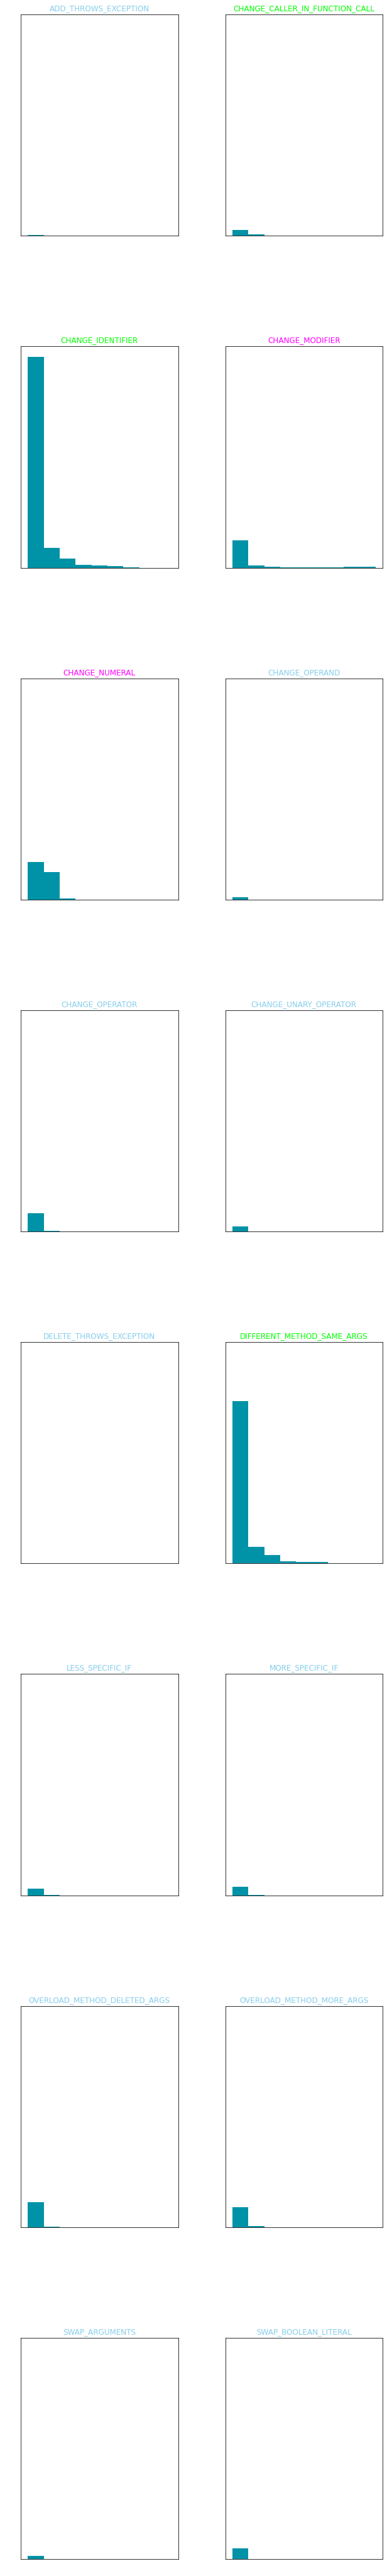

In [16]:
plot_hist(sharey=True)

#### Variable Height
> In the following plots, all histograms will have a height based on the
> amount of data inside the group.
> This will help to analyze how different refix lengths are distributed
> inside a single bug-type

array([[<AxesSubplot:title={'center':'ADD_THROWS_EXCEPTION'}>,
        <AxesSubplot:title={'center':'CHANGE_CALLER_IN_FUNCTION_CALL'}>],
       [<AxesSubplot:title={'center':'CHANGE_IDENTIFIER'}>,
        <AxesSubplot:title={'center':'CHANGE_MODIFIER'}>],
       [<AxesSubplot:title={'center':'CHANGE_NUMERAL'}>,
        <AxesSubplot:title={'center':'CHANGE_OPERAND'}>],
       [<AxesSubplot:title={'center':'CHANGE_OPERATOR'}>,
        <AxesSubplot:title={'center':'CHANGE_UNARY_OPERATOR'}>],
       [<AxesSubplot:title={'center':'DELETE_THROWS_EXCEPTION'}>,
        <AxesSubplot:title={'center':'DIFFERENT_METHOD_SAME_ARGS'}>],
       [<AxesSubplot:title={'center':'LESS_SPECIFIC_IF'}>,
        <AxesSubplot:title={'center':'MORE_SPECIFIC_IF'}>],
       [<AxesSubplot:title={'center':'OVERLOAD_METHOD_DELETED_ARGS'}>,
        <AxesSubplot:title={'center':'OVERLOAD_METHOD_MORE_ARGS'}>],
       [<AxesSubplot:title={'center':'SWAP_ARGUMENTS'}>,
        <AxesSubplot:title={'center':'SWAP_BOOLEAN_LIT

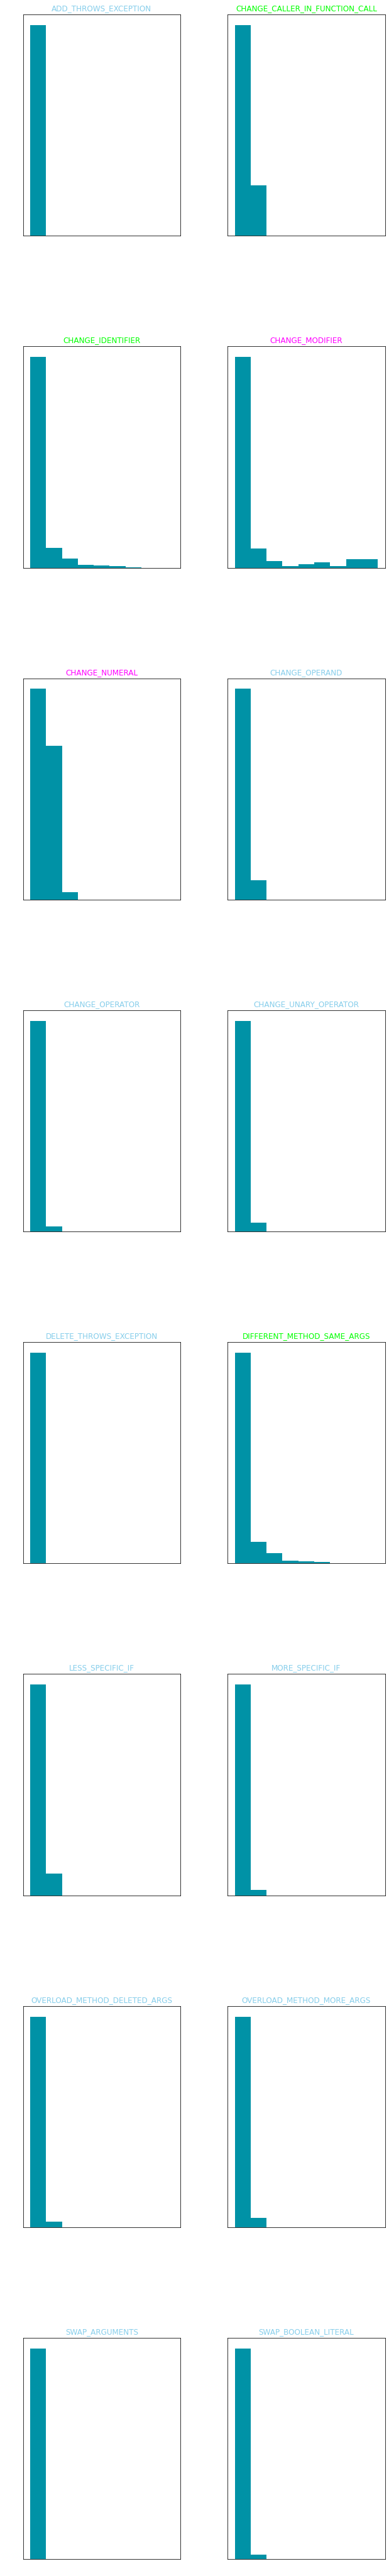

In [17]:
plot_hist(sharey=False)

### Central Tendency

In [18]:
central_tendency_df = fix_df.groupby('type').distance\
    .agg(['count', 'mean', 'median', pd.Series.mode])\
    .sort_values('mean', ascending=False)
central_tendency_df

,count,mean,median,mode
type,,,,
CHANGE_MODIFIER,156,2.955128,2,2
CHANGE_NUMERAL,295,2.454237,2,2
DIFFERENT_METHOD_SAME_ARGS,849,2.282686,2,2
CHANGE_IDENTIFIER,1086,2.256906,2,2
CHANGE_CALLER_IN_FUNCTION_CALL,31,2.193548,2,2
LESS_SPECIFIC_IF,32,2.093750,2,2
CHANGE_OPERAND,12,2.083333,2,2
OVERLOAD_METHOD_MORE_ARGS,92,2.043478,2,2
CHANGE_UNARY_OPERATOR,24,2.041667,2,2


### Variance

In [19]:
variance_df = fix_df.groupby('type').distance\
    .agg(['count', 'min', 'max', 'var', 'std'])\
    .sort_values('var', ascending=False)
variance_df

,count,min,max,var,std
type,,,,,
CHANGE_MODIFIER,156,2,12,5.501199,2.345464
DIFFERENT_METHOD_SAME_ARGS,849,2,8,0.641693,0.801057
CHANGE_IDENTIFIER,1086,2,8,0.580021,0.761591
CHANGE_NUMERAL,295,2,4,0.289565,0.538113
CHANGE_CALLER_IN_FUNCTION_CALL,31,2,3,0.161290,0.401610
LESS_SPECIFIC_IF,32,2,3,0.087702,0.296145
CHANGE_OPERAND,12,2,3,0.083333,0.288675
OVERLOAD_METHOD_MORE_ARGS,92,2,3,0.042045,0.205049
CHANGE_UNARY_OPERATOR,24,2,3,0.041667,0.204124


### Symmetry

In [20]:
symmetry_df = fix_df.groupby('type').distance\
    .agg(['count', 'skew', pd.Series.kurt])\
    .sort_values('skew', ascending=False)
symmetry_df

,count,skew,kurt
type,,,
SWAP_BOOLEAN_LITERAL,50,7.071068,50.000000
CHANGE_OPERATOR,83,6.321651,38.900320
MORE_SPECIFIC_IF,39,6.244998,39.000000
OVERLOAD_METHOD_DELETED_ARGS,114,5.997569,34.577237
CHANGE_UNARY_OPERATOR,24,4.898979,24.000000
OVERLOAD_METHOD_MORE_ARGS,92,4.551767,19.134168
CHANGE_IDENTIFIER,1086,3.832646,16.734641
DIFFERENT_METHOD_SAME_ARGS,849,3.682333,15.433599
CHANGE_OPERAND,12,3.464102,12.000000
